# Lesson 5: Remote Data Science!

<b><u>Instructors</b></u>: Ishan Mishra, Phil Culliton


In this lesson, we're going to see what it's like to be a data scientist working with remote data through PySyft. We'll be making use of the same tabular COVID19 dataset that we cleaned, annotated, and uploaded in Lesson 3.

In [1]:
import syft as sy
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import os
import pandas as pd
import time

%matplotlib inline

#### Log into domain

Here we log into your new node using a non-admin data scientist account. If you used a different email / password
combination to create the data scientist account, enter it here.

In [2]:
ds_domain = sy.login(
    email = "sheldon@caltech.edu",
    password = "bazinga",
    port = 8081
)

Connecting to http://localhost:8081... done! 	 Logging into new_phil_node... done!


#### Check privacy budget

The privacy budget represents how much noise the data scientist can remove from a dataset when accessing it. Domains will set a privacy budget per data scientist. More (in this case, 100) can be requested using:

`ds_domain.request_privacy_budget(100)`

In [3]:
ds_domain.privacy_budget

100.0

#### List datasets on domain

There is only one dataset attached to this domain currently - let's take a look! The following command shows the data scientist:
1. The name and index of the available datasets.
2. A description, as entered by the data owner.
3. Any assets contained within the dataset - usually tensors or groups of tensors - and their names. In this case we just have string indices.
4. A unique ID - this can be used to access the dataset in addition to the index.

In [4]:
ds_domain.datasets

#### Select the COVID dataset

`covid_ds` is a pointer to the dataset above.

In [5]:
covid_ds = ds_domain.datasets[-1]

In [6]:
# covid_ds

#### Access the tensors in the dataset

1. Create `result` - a pointer to one of the selected dataset's tensors.

In [7]:
result = covid_ds["Country 0"]

2. `publish` uses the privacy budget approved by the data owner to access the data in a noised format that does not compromise the original dataset. `sigma` is the amount of privacy budget the data scientist plans to use.

In [8]:
published_result = result.publish(sigma=10)

3. We call `get()` to access the contents of the `published_result` pointer created above.

In [11]:
published_result.get()

array([  1.87962505,   4.71938444,   0.21009209,  11.6951488 ,
         1.65871529,   7.51741406,  -2.69433908,   6.69456906,
         9.47428484,   2.95521849,   6.6730533 ,  -5.14659351,
        17.93966438,   2.96712695,   1.68368624,  -7.09433619,
       -19.40986988,  -5.46137163,  -4.09276642,  13.18786713,
        17.52276474,  22.4753219 , -23.93438919,  -5.97426366,
       -10.57195696,   8.46965483,  -2.20720727,  -3.57068655,
         2.16387452,  13.52685285,  -1.19839955, -10.9106257 ,
         4.29427713,  -0.13939782,  -7.40138386,  13.52924455,
         3.6314732 ,   0.54333269,  -8.26701998, -13.7421667 ,
       -17.83994344,  -6.27095021,   2.80863972, -11.48666258,
         9.6186131 , -16.55402525,  13.72067735, -17.28392862,
        -4.05404757, -10.67938915,  -3.42309606,  -9.16542317,
        -3.10181604,  -0.25535211])

#### Great! Now let's access a portion of the dataset in the same way.

Note that we are setting `sigma=10` for each object. In this case each object represents a different country's weekly COVID numbers - each country is a "data subject" or "entity". We pause between each `publish` and `get` call to allow the server to receive the request and prepare the necessary data.

In [12]:
published_data = []

## "countries" 24 and 129 had the best / worst rates of infection
for i in [24, 129] + list(range(5)):
    result = covid_ds[f'Country {i}']
    published_result = result.publish(sigma=10)
    time.sleep(10)
    published_data.append(published_result.get())
    print(ds_domain.privacy_budget)
    
published_data = np.asarray(published_data)

100.0
100.0
100.0
100.0
100.0
100.0
100.0


In [13]:
len(published_data)

7

#### Load the dataset portion into a Pandas dataframe.

Let's plot the noisy data as well. In comparison to the data visualized in Lesson 3, it is impossible (thanks to differential privacy) to tell which country is which - but the machine learning properties of the data remain the same.

(<AxesSubplot:>,
           0          1         2          3          4          5          6   \
 0  20.336905  -8.964656 -2.982325  10.859373   5.490088  -1.173325   2.693699   
 1  -6.128690 -13.911575  2.626617  12.566412   4.911579  -3.845937   9.437008   
 2   1.371150  -3.700766  8.279892  -8.007940  -0.912172   0.194758   3.440402   
 3  24.991676  -4.794710 -0.667047   0.743543   6.049031  13.066630  14.961670   
 4  -1.400285  -7.923442 -8.091082   3.726426  34.372218  -8.666324   4.028763   
 5   9.683693   1.340415  2.241332  -3.487355  10.334584   1.303773 -12.435732   
 6  -4.006095   8.412063 -1.585492   5.913141  16.689908  -8.757812 -14.523390   
 
           7         8          9   ...        44         45        46  \
 0  -9.795669 -5.619013  -3.486675  ...  8.072695  -2.876978 -7.555695   
 1   8.366968 -2.278678   7.517804  ... -7.568879   5.685375  3.052952   
 2  -7.312792 -6.719416  -7.905397  ...  9.455157  22.467539  5.925469   
 3  20.595809 -6.638701  -1.2

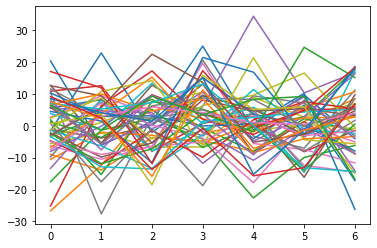

In [14]:
data_df = pd.DataFrame(published_data)
data_df.plot(legend=False), data_df

In [15]:
# data_df["total_cases_per_week"] = data_df.sum(1)
# data_df.plot(legend=False)

#### Let's focus on two countries

One had the best (lowest) infection rate and one had the worst (highest) infection rate.

<AxesSubplot:>

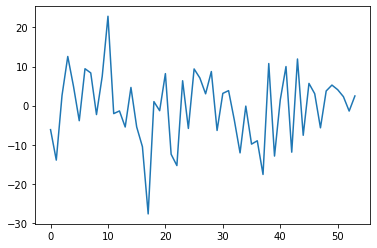

In [16]:
data_df.loc[1].plot()

<AxesSubplot:>

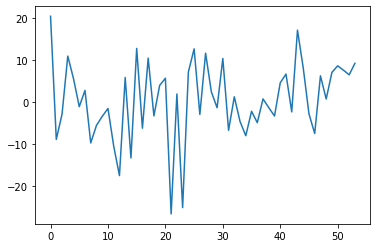

In [17]:
data_df.loc[0].plot()

#### And extrapolate out 3 more months

In [21]:
def plot_extrapolated_country(idx):
    x = list(range(54))
    y = data_df.loc[idx].values

    plt.plot(y)
    
    z = np.polyfit(x, y, 2)
    f = np.poly1d(z)

    new_points = range(12)
    new_y = []
    for x2 in new_points:
        new_y.append(f(55+x2))
        
    plt.plot(range(54, 66), new_y)

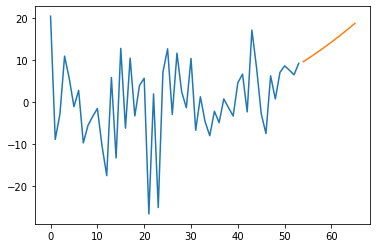

In [22]:
plot_extrapolated_country(0)

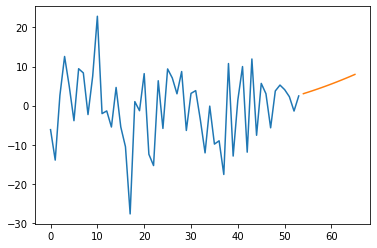

In [23]:
plot_extrapolated_country(1)

#### We've done some data science!

As you can see above, again, the data is obscured by noise, but the trends / modeling move in the expected direction for each set of data.

### Congratulations!

We've done data science work with a dataset on your node - a dataset that's protected by privacy enhancing technologies!